In [410]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [411]:
def load_data():
    data = pd.read_csv('./Telco-Customer-Churn.csv')
    return data
df = load_data()
df = df.replace(' ', pd.NA)
df = df.dropna()

In [412]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [413]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7032
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [414]:
cat_cols, num_cols, cat_but_car

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn',
  'SeniorCitizen'],
 ['tenure', 'MonthlyCharges'],
 ['customerID', 'TotalCharges'])

In [415]:

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    label_encoder(df, col)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,1,Mailed check,84.80,1990.5,0
7039,2234-XADUH,0,0,1,1,72,1,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,1,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,0,0,1,1,11,0,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,1,Electronic check,29.60,346.45,0
7041,8361-LTMKD,1,1,1,0,4,1,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Mailed check,74.40,306.6,1


In [416]:
for col in cat_cols:
    try:
        print(f'Churn and {col} : %{int(df[df["Churn"] == 1][col].mean()*100)}')
    except:
        pass

Churn and gender : %49
Churn and Partner : %35
Churn and Dependents : %17
Churn and PhoneService : %90
Churn and PaperlessBilling : %74
Churn and Churn : %100
Churn and SeniorCitizen : %25


In [417]:
for col in num_cols:
    print(f'Churn and {col} : {df[df["Churn"] == 1][col].mean()}')

Churn and tenure : 17.979133226324237
Churn and MonthlyCharges : 74.44133226324237


Aykırı değer analizi

In [418]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [419]:
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False


Eksik değer analizi

In [420]:
df.isnull().values.any()

False

Korelasyon Analizi

C:\Users\yadem\AppData\Local\Temp\ipykernel_5664\4164286026.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())
C:\Users\yadem\AppData\Local\Temp\ipykernel_5664\4164286026.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df.corr()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
Churn,-0.008545,0.150541,-0.149982,-0.163128,-0.354049,0.011691,0.191454,0.192858,1.000000
Dependents,0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.110131,-0.112343,-0.163128
MonthlyCharges,-0.013779,0.219874,0.097825,-0.112343,0.246862,0.248033,0.351930,1.000000,0.192858
PaperlessBilling,-0.011902,0.156258,-0.013957,-0.110131,0.004823,0.016696,1.000000,0.351930,0.191454
Partner,-0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,-0.013957,0.097825,-0.149982


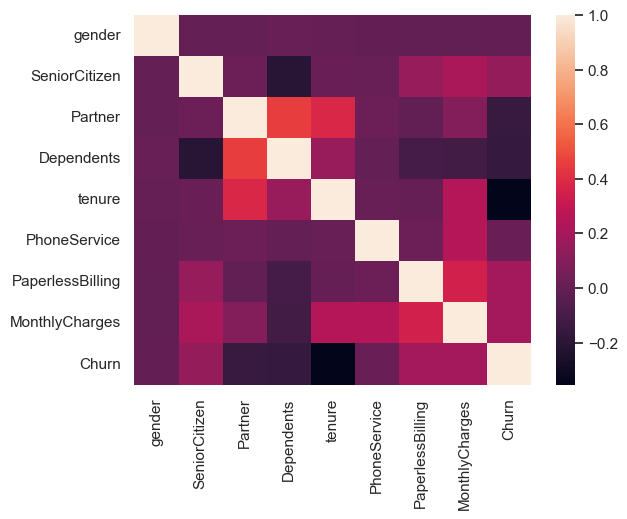

In [421]:
sns.heatmap(df.corr())
data = df.corr()
data.sort_index()[0:5]

In [422]:
dffa = df ## eklenilen özelliklerden önce kullanılacak data


One Hot Encoding

In [423]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [424]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

dff = df
df = dffa 

df.loc[(df["Partner"] == 0) & (df["Dependents"] == 0), 'Family_Size'] = 1
df.loc[(df["Partner"] == 1) ^ (df["Dependents"] == 1), 'Family_Size'] = 2
df.loc[(df["Partner"] == 1) & (df["Dependents"] == 1), 'Family_Size'] = 3


df['HasPhoneAndInternet'] = (df['PhoneService'] == 1) & (df['InternetService'] != 0)


df['SecurityBackupCombo'] = df['OnlineSecurity'] + '_' + df['OnlineBackup'] + '_' + df['DeviceProtection']


df['MonthlyChargesPerService'] = df['MonthlyCharges'] / (df['InternetService'] != 'Hayır') + (df['PhoneService'] == 'Evet')
df.loc[df['InternetService'] == 'Hayır', 'MonthlyChargesPerService'] = 0.0


ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)


Model eğitimi

In [425]:

y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7890995260663507

In [427]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8028436018957346

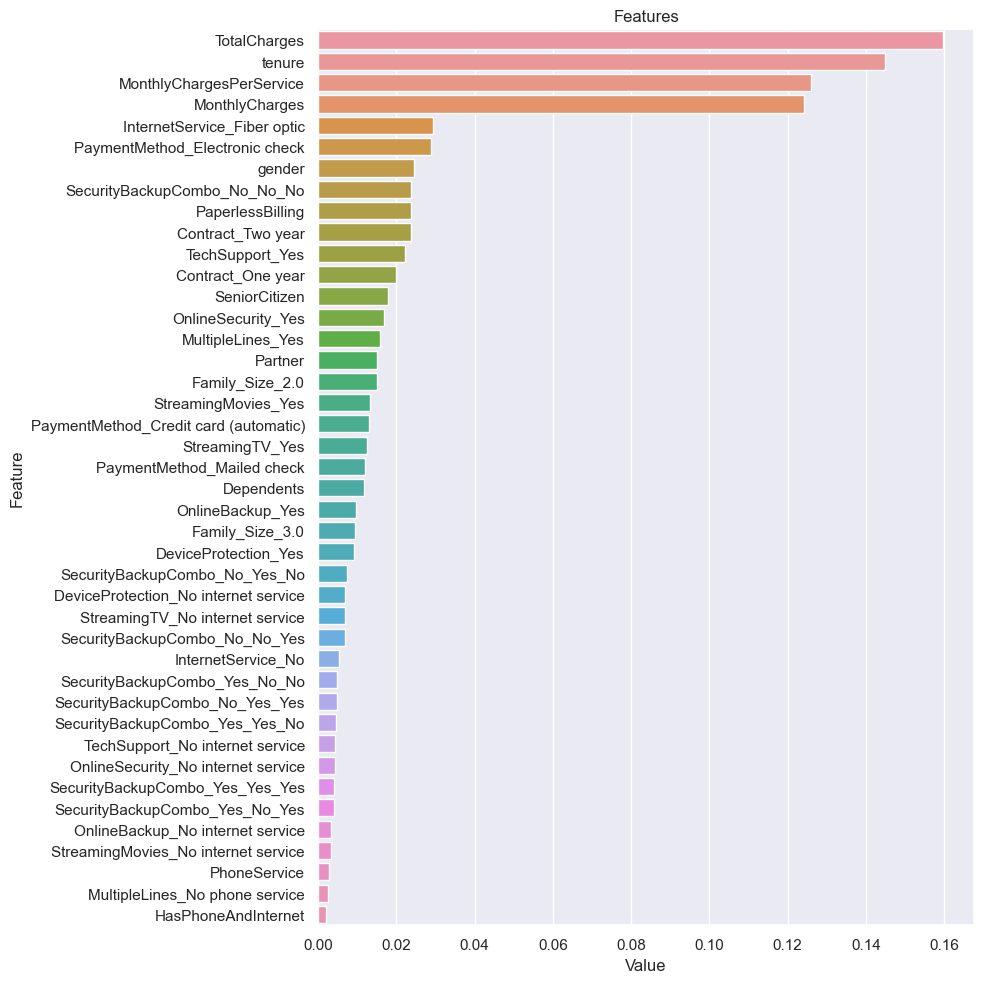

In [428]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)